# Tugas 2 Reinforcement Learning
## Kelompok 8
Anggota:
* M. Wahyu Ramansyah (Persevere)
* Dimas Aditya Kristianto (Visioner)
* Indah Tyastika (Atlas)
* Arin Putri Adelia (Alan Turing)




Cari satu kasus di environment OpenAI yang bisa diselesaikan dengan Monte Carlo, pelajari programnya.
1.	Jelaskan yang anda pahami tentang mekanisme kerja dari program tersebut!

### Jawaban
Salah satu kasus yang terdapat pada environment OpenAI yang dapat diselesaikan dengan menggunakan Monte Carlo adalah permainan kartu Blackjack. Aturan pada permainan ini adalah sebagai berikut.
* Tujuan dari permainan kartu Blackjack yaitu untuk mendapatkan kartu yang jumlah nilainya sebanyak mungkin tanpa melebihi 21. Apabila jumlah nilainya lebih dari 21 maka pemain akan langsung kalah, Apabila pemain dan dealer mempunyai jumlah nilai yang sama maka akan seri.
* Pada contoh ini yang bermain adalah pemain bermain secara independen dengan dealer.
* Nilai kartu sesuai dengan nilai nominal yang terdapat pada kartu. Jika kartu tersebut merupakan J, Q, K nilainya yaitu 10, dan jika kartunya As maka nilainya 1 atau 11 tergantung pilihan pemain.
* Kedua pihak, pemain dan dealer akan diberikan dua kartu awal yang mana kedua kartu pemain akan menghadap ke atas (terbuka), sedangkan kartu dealer hanya 1 yang menghadap ke atas satunya lagi menghadap ke bawah (tertutup). Setelah pemain melihat kedua kartunya dan 1 kartu dealer maka ia dapat menentukan pilihan hit atau stick. Jika memilih stick maka akan mendapatkan 1 tambahan kartu sampai ia merasa puas dengan jumlah nilai kartunya.
* Dealer kemudian membuka kartu keduanya. Jika jumlahnya kurang dari 17 maka dealer akan terus melakukan draw kartu sampai 17 tercapai.



### Import Library dan buat Environment

In [1]:
import sys
import gym
import numpy as np
from collections import defaultdict
env = gym.make('Blackjack-v0')
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


Pada environment blackjack yang tersedia pada OpenAI. Terdapa tuple yang terdiri dari.
* Penjumlahan kartu pemain {0,1,2,...,31}
* Jumlah kartu pertama dealer {1,2,...,11}
* Kondisi apabila pemain menggunakan kartu As atau tidak (True = Menggunakan As, False = Tidak menggunakan As)

### Contoh sekali permainan kartu Blackjack

In [41]:
state = env.reset()
i = 0
while True:
       print(i+1)
       print(state)
       action = env.action_space.sample()
       state, reward, done, info = env.step(action)
       print(state)
       print(info)
       i = i+1
       if done:
          if reward > 0: 
             print('Reward: ', reward, '(Player won)\n')
          else: 
             print('Reward: ', reward, '(Player lost)\n')
          break

1
(12, 1, False)
(13, 1, False)
{}
2
(13, 1, False)
(18, 1, False)
{}
3
(18, 1, False)
(22, 1, False)
{}
Reward:  -1.0 (Player lost)



### Membuat Episode
Satu episode selesai ketika seluruh rangkaian seperti action, state, reward telahh diselesaikan oleh pemain. Terdapat probabilatas yang dibuat yaitu 75% pemain akan memilih stick dan 25 pemain akan memilih hit jika jumlah kedua kartunya bernilai lebih dari 18. Apabila jumlah kedua kartunya kurang dari atau sama dengan 18 makan probabilitas action yang akan dipilih pemain yaitu 25% stick dan 75% hit

In [42]:
def generate_episode(env):
    episode = []
    state = env.reset() 
    while True:
        probs = [0.75, 0.25] if state[0] > 18 else [0.25, 0.75]
        action = np.random.choice(np.arange(2), p=probs)
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
           break
    return episode

In [43]:
for i in range(10):
    print(generate_episode(env))

[((17, 4, True), 1, 0.0), ((14, 4, False), 1, 0.0), ((18, 4, False), 1, -1.0)]
[((10, 10, False), 1, 0.0), ((20, 10, False), 0, 0.0)]
[((12, 2, False), 1, 0.0), ((20, 2, False), 0, 1.0)]
[((18, 4, False), 1, -1.0)]
[((12, 10, False), 1, -1.0)]
[((7, 9, False), 1, 0.0), ((17, 9, False), 1, -1.0)]
[((16, 2, True), 1, 0.0), ((12, 2, False), 1, -1.0)]
[((18, 9, False), 0, 0.0)]
[((13, 2, True), 1, 0.0), ((13, 2, False), 1, -1.0)]
[((14, 9, False), 0, 1.0)]


### Monte Carlo pada Blackjack OpenAI Environment
<img src="https://miro.medium.com/max/627/1*bwwT1Jk-fz-n18m9iw9qRw.png">

Pada Pseudocode diatas, variable num_episodes menunjukan jumlah episode yang dilakukan oleh agen (dalam hal ini yaitu pemain). Dan terdapat tiga tabel yang relevan.
* Q : Q-Tabel dengan baris untuk state dan kolom untuk action
* N : Tabel jumlah kunjungan pertama ke setiap pasangan action-state
* return_sum : Tabel jumlah reward yang diperoleh setelah kunjungan pertama ke setiap pasangan state-action.

Setelah setiap episode, tabel N dan return_sum akan diperbarui untuk menyimpan informasi yang terkandung dalam episode. Estimasi akhir untuk tabel Q dilakukan seteleh semua episode dikumpulkan


In [45]:
N = defaultdict(lambda: np.zeros(env.action_space.n))
returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
Q = defaultdict(lambda: np.zeros(env.action_space.n))

In [46]:
episode = generate_episode(env)
states, actions, rewards = zip(*episode)

In [47]:
def mc_prediction(env, num_episodes, generate_episode, gamma=1.0):
   
   returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
   N = defaultdict(lambda: np.zeros(env.action_space.n))
   Q = defaultdict(lambda: np.zeros(env.action_space.n))
   for episode in range(1, num_episodes+1):
      episode = generate_episode(env)
      states, actions, rewards = zip(*episode)
      discounts = np.array([gamma**i for i in range(len(rewards)+1)])
      for i, state in enumerate(states):
          returns_sum[state][actions[i]] += sum(rewards[i:]*discounts[:-(1+i)])
          N[state][actions[i]] += 1.0
          Q[state][actions[i]] = returns_sum[state][actions[i]] / N[state][actions[i]]
   return Q

In [48]:
num_episodes=1000000
Q = mc_prediction(env, num_episodes, generate_episode)
State_Value_table={}
for state, actions in Q.items():
  State_Value_table[state]= (state[0]>18)*(np.dot([0.75, 0.25],actions)) +(state[0]<=18)*(np.dot([0.75, 0.25],actions))

In [52]:
State_Value_table

{(4, 1, False): -0.792621584618132,
 (4, 2, False): -0.34867310937260315,
 (4, 3, False): -0.324324494156089,
 (4, 4, False): -0.24745233399079553,
 (4, 5, False): -0.24410377358490565,
 (4, 6, False): -0.06318681318681318,
 (4, 7, False): -0.4699010158895546,
 (4, 8, False): -0.3494883020551574,
 (4, 9, False): -0.4363387978142076,
 (4, 10, False): -0.5599581164128861,
 (5, 1, False): -0.7749544134530966,
 (5, 2, False): -0.2707232953780318,
 (5, 3, False): -0.280518718810267,
 (5, 4, False): -0.2187767939116645,
 (5, 5, False): -0.14165796015419535,
 (5, 6, False): -0.18978949439307496,
 (5, 7, False): -0.5074697589933266,
 (5, 8, False): -0.4773103358303751,
 (5, 9, False): -0.50018573551263,
 (5, 10, False): -0.5983552178572925,
 (6, 1, False): -0.7168710477587954,
 (6, 2, False): -0.35052067662889047,
 (6, 3, False): -0.29896920175989944,
 (6, 4, False): -0.3166664147292681,
 (6, 5, False): -0.269776456420292,
 (6, 6, False): -0.2595216580190054,
 (6, 7, False): -0.476751373626373

In [51]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_blackjack_values(V):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in V:
            return V[x,y,usable_ace]
        else:
            return 0

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(1, 11)
        X, Y = np.meshgrid(x_range, y_range)
        
        Z = np.array([get_Z(x,y,usable_ace) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.set_zlabel('State Value')
        ax.view_init(ax.elev, -120)

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(211, projection='3d')
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(212, projection='3d')
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

def plot_policy(policy):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in policy:
            return policy[x,y,usable_ace]
        else:
            return 1

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(10, 0, -1)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([[get_Z(x,y,usable_ace) for x in x_range] for y in y_range])
        surf = ax.imshow(Z, cmap=plt.get_cmap('Pastel2', 2), vmin=0, vmax=1, extent=[10.5, 21.5, 0.5, 10.5])
        plt.xticks(x_range)
        plt.yticks(y_range)
        plt.gca().invert_yaxis()
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.grid(color='w', linestyle='-', linewidth=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0,1], cax=cax)
        cbar.ax.set_yticklabels(['0 (STICK)','1 (HIT)'])
            
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(121)
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(122)
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

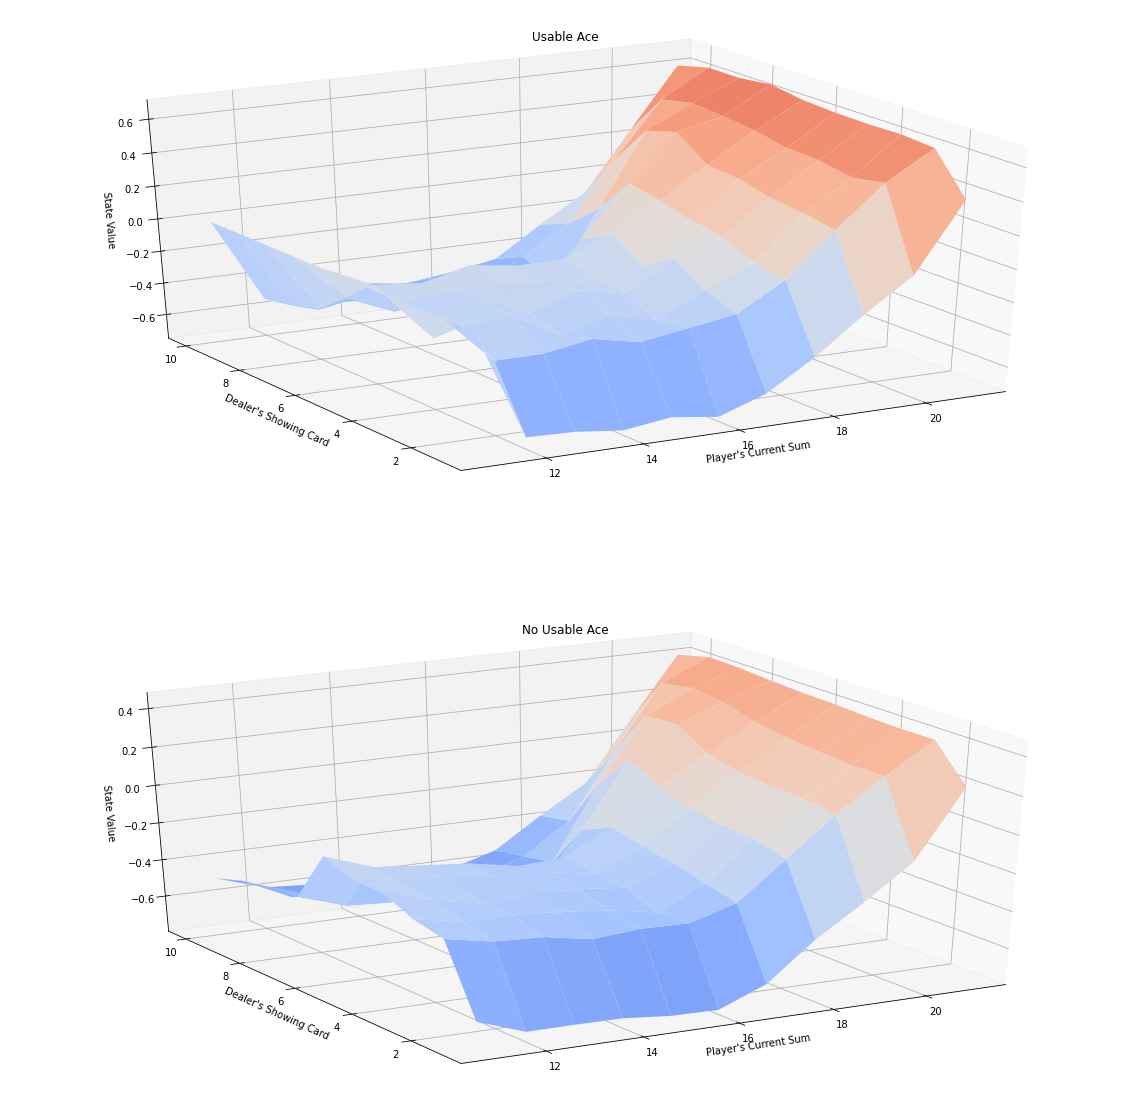

In [53]:
plot_blackjack_values(State_Value_table)